In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import math as mt
from joblib import dump, load

import datetime

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sklearn.model_selection import train_test_split
from random import seed
from random import randint
import statistics
from scipy.stats import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time


In [2]:
# Load X and y values
X = load('./Input/X_1984-2014.joblib') 
X

y= load('./Input/y_1984-2014.joblib')
y

<xarray.DataArray 'fogdata' (time: 1922)>
array([0.16, 0.28, 0.32, ..., 0.76, 0.72, 0.76])
Coordinates:
  * time     (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2014-12-31

In [3]:
# Load X and y values
Xt = load('./Input/Xtest_1980-1983_2015-2018.joblib') 

yt= load('./Input/ytest_1980-1983_2015-2018.joblib')


Accuracy of base GB model is , 0.7508661665037253


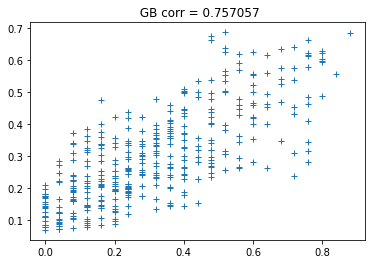

In [4]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
regLin=GradientBoostingRegressor(n_estimators=500, min_samples_leaf=5, max_depth= 3,learning_rate=0.01,random_state=0).fit(X_train, y_train)
acc_svr       = round(regLin.score(X_test, y_test) * 100, 2)
print("Accuracy of base GB model is ,",(acc_svr/100)**0.5)
yy_test = regLin.predict(X_test)
test_corr = np.corrcoef(yy_test,y_test)[0,1]
plt.title(' GB corr = %f'%test_corr)
plt.plot(y_test,yy_test,'+')

In [5]:
regLin=GradientBoostingRegressor(n_estimators=500, min_samples_leaf=5, max_depth= 3,learning_rate=0.01,random_state=0).fit(X, y)

Accuracy of base GB model is , 0.7019971509913697


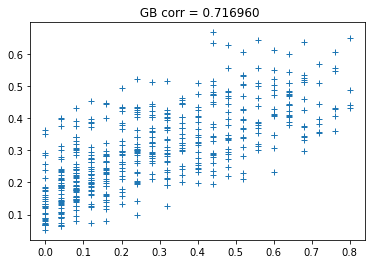

In [6]:
yPred = regLin.predict(Xt)
testcorr = np.corrcoef(yPred,yt)[0,1]
acc_svr       = round(regLin.score(Xt, yt) * 100, 2)
print("Accuracy of base GB model is ,",(acc_svr/100)**0.5)
plt.title(' GB corr = %f'%testcorr)
plt.plot(yt,yPred,'+')

In [7]:
yLR=regLin.predict(X)

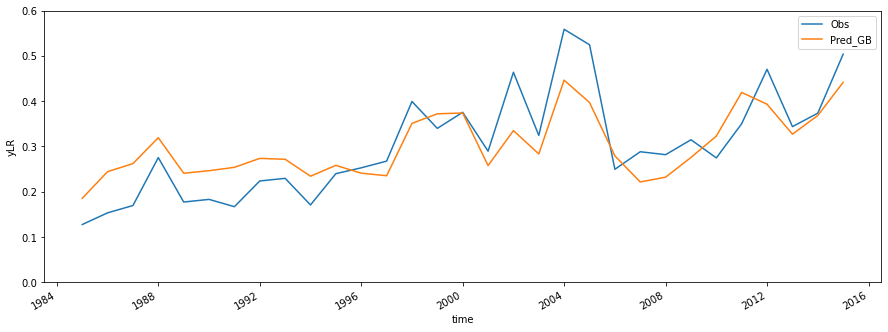

In [8]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR)}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataGB_3.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_GB')
#dump(y,'TS1dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()


In [9]:
ynf=y.where(y<0.040, drop=True)
print(ynf.shape[0])

yint1=y.where(y>=0.04,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
print(yintf.shape[0])

yWd=y.where(y>=0.48, drop=True)
print(yWd.shape[0])

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)
print(yLRnf.yLR.shape[0])

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>=0.04,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)
print(yLRintf.yLR.shape[0])

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>=0.48,drop=True)
print(yLRWd.yLR.shape[0])

print((ynf.shape[0]+yintf.shape[0]+yWd.shape[0]))
print((yLRnf.yLR.shape[0]+yLRintf.yLR.shape[0]+yLRWd.yLR.shape[0]))

90
1361
471
0
1663
259
1922
1922


Text(0.5, 1.0, 'GB')

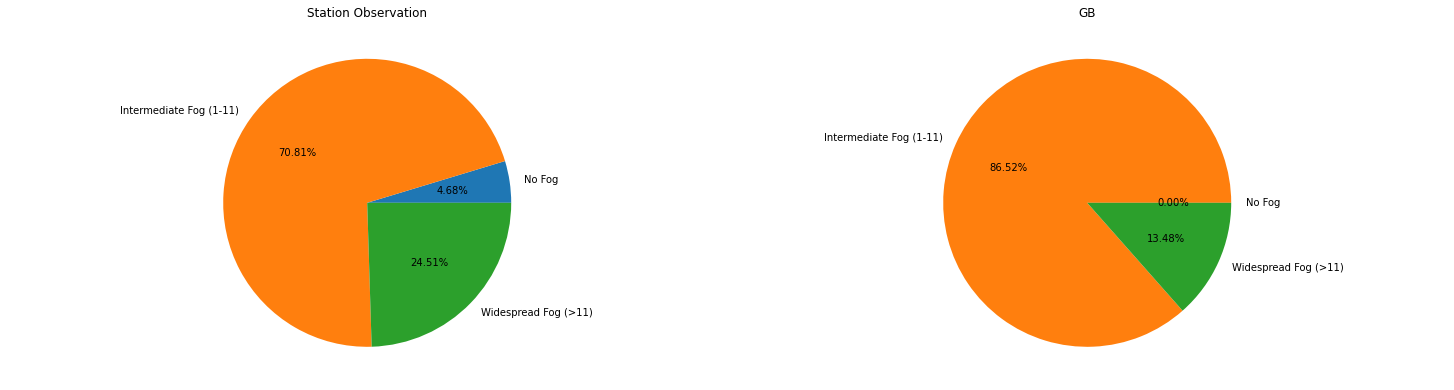

In [10]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')
ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('GB')
#fig.savefig('../StationLRP1.jpeg',dpi=100)

In [11]:
pie1dataObs = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
pie1dataLR = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
#dump(pie1dataObs, 'pie1dataObs_1.joblib') 
dump(pie1dataLR,'pie1dataGB_3.joblib')

['pie1dataGB_3.joblib']

In [12]:
yLRt=regLin.predict(Xt)

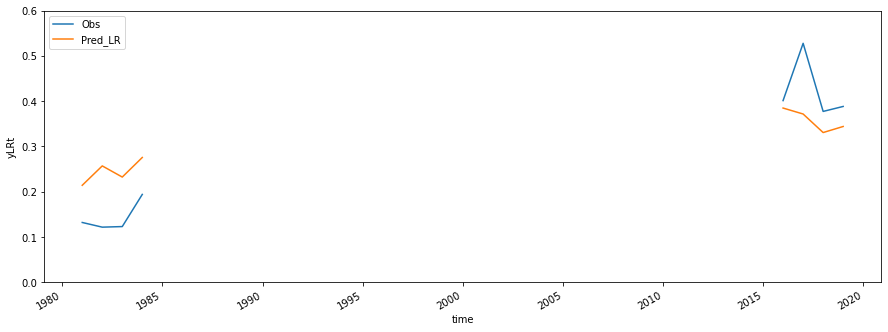

In [13]:
y_predLin_dst=xr.Dataset({'yLRt': (('time'), yLRt)}, coords={'time': yt.time})
dump(y_predLin_dst.yLRt,'TS2dataGB_3.joblib')
plt.figure(figsize=[15,5])
yt.resample(time='1Y').mean().plot(label='Obs')
y_predLin_dst.resample(time='1Y').mean().yLRt.plot(label='Pred_LR')
##dump(yt,'TS2dataObs_1.joblib')
plt.ylim(0, 0.6)
plt.legend()

In [14]:
ynft=yt.where(yt<0.040, drop=True)
print(ynft.shape[0])

yint1t=yt.where(yt>=0.04,drop=True)
yintft=yint1t.where(yint1t<0.48,drop=True)
print(yintft.shape[0])

yWdt=yt.where(yt>=0.48, drop=True)
print(yWdt.shape[0])

print((ynft.shape[0]+yintft.shape[0]+yWdt.shape[0]))

yLRnft=y_predLin_dst.where(y_predLin_dst.yLRt<0.04,drop=True)
print(yLRnft.yLRt.shape[0])

yLRint1t=y_predLin_dst.where(y_predLin_dst.yLRt>=0.04,drop=True)
yLRintft=yLRint1t.where(yLRint1t<0.48,drop=True)
print(yLRintft.yLRt.shape[0])

yLRWdt=y_predLin_dst.where(y_predLin_dst.yLRt>=0.48,drop=True)
print(yLRWdt.yLRt.shape[0])

print((yLRnft.yLRt.shape[0]+yLRintft.yLRt.shape[0]+yLRWdt.yLRt.shape[0]))

35
344
117
496
0
449
47
496


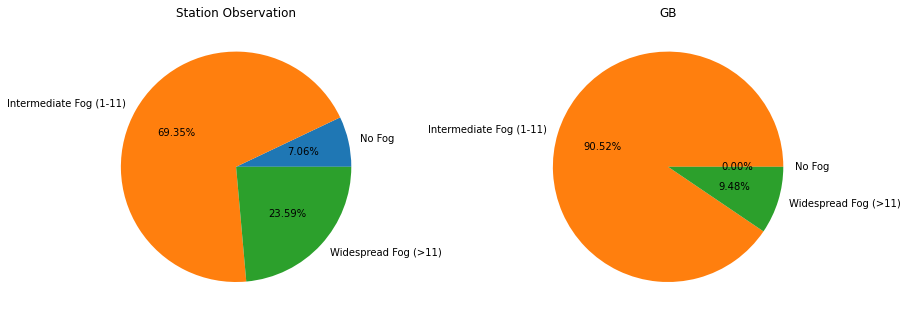

In [15]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('GB')
plt.show()



In [16]:
pie1dataObs = [ynft.shape[0],yintft.shape[0],yWdt.shape[0]]
pie1dataLR = [yLRnft.yLRt.shape[0],yLRintft.yLRt.shape[0],yLRWdt.yLRt.shape[0]]
#dump(pie1dataObs, 'pie2dataObs_1.joblib') 
dump(pie1dataLR,'pie2dataGB_3.joblib')

['pie2dataGB_3.joblib']